<a href="https://colab.research.google.com/github/88FaHaD/ML/blob/main/transfer_lerning_mobilenet_vs_efficentnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transfer learning
Taking the already creted model and fiting it to our model

In [1]:
import zipfile

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref=zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()


--2024-02-27 17:17:27--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 142.250.101.207, 2607:f8b0:4023:c0d::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   146MB/s    in 1.1s    

2024-02-27 17:17:28 (146 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:

# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

# Preapearing the data

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:

IMAGE_SHAPE = (160, 160)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


# Creating a tensor board call back

In [6]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


# Prepering transfer learning

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
mobinet="https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-160-feature-vector/versions/2"
effinet="https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b1-feature-vector/versions/2"

In [9]:
def create_model(model_url,num_classes=10):
  #downloading the pretrained model and save it as keras layer
  feature_extraction_layer=hub.KerasLayer(model_url,
                                          trainable=False, # freezing already learned patterns by model
                                          name='Feature_extraction_layer',
                                          input_shape=IMAGE_SHAPE +(3,))
  #The model will pass through pretrained model  and the then will move to our model
  model=tf.keras.Sequential([
      feature_extraction_layer,
      layers.Dense(num_classes,activation='softmax',name='oytput_layer')
  ])

  return model

#Creating mobileinet model


In [10]:
mobilenet_model=create_model(mobinet,num_classes=train_data_10_percent.num_classes)

In [11]:
mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 1280)              410208    
 KerasLayer)                                                     
                                                                 
 oytput_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 423018 (1.61 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 410208 (1.56 MB)
_________________________________________________________________


# Compiling the Model

In [12]:
mobilenet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                        metrics=['accuracy']
)

#Fiting the model

In [13]:
mobile_history=mobilenet_model.fit(train_data_10_percent,
                                   epochs=10,
                                   steps_per_epoch=(len(train_data_10_percent)),
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                          experiment_name='mobilenetv2')]
                                   )

Saving TensorBoard log files to: tensorflow_hub/mobilenetv2/20240227-171736
Epoch 1/10
24/24 [==============================] - 33s 1s/step - loss: 1.9984 - accuracy: 0.3160 - val_loss: 1.4480 - val_accuracy: 0.5544
Epoch 2/10
24/24 [==============================] - 9s 370ms/step - loss: 1.2225 - accuracy: 0.6480 - val_loss: 1.1377 - val_accuracy: 0.6608
Epoch 3/10
24/24 [==============================] - 8s 339ms/step - loss: 0.9456 - accuracy: 0.7427 - val_loss: 1.0131 - val_accuracy: 0.6884
Epoch 4/10
24/24 [==============================] - 13s 542ms/step - loss: 0.7821 - accuracy: 0.7853 - val_loss: 0.9654 - val_accuracy: 0.6896
Epoch 5/10
24/24 [==============================] - 8s 364ms/step - loss: 0.6614 - accuracy: 0.8200 - val_loss: 0.9196 - val_accuracy: 0.7080
Epoch 6/10
24/24 [==============================] - 9s 408ms/step - loss: 0.5734 - accuracy: 0.8613 - val_loss: 0.8922 - val_accuracy: 0.7188
Epoch 7/10
24/24 [==============================] - 9s 392ms/step - loss:

#Ploting the Losscurve

In [14]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


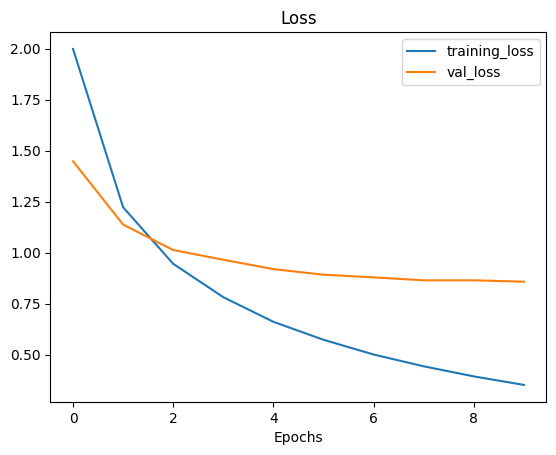

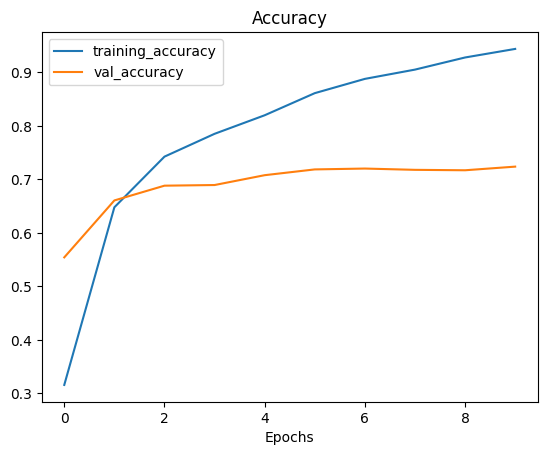

In [15]:
plot_loss_curves(mobile_history)

In [18]:
effinet_model=create_model(effinet,num_classes=train_data_10_percent.num_classes)

In [19]:
effinet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Feature_extraction_layer (  (None, 1280)              6931124   
 KerasLayer)                                                     
                                                                 
 oytput_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 6943934 (26.49 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 6931124 (26.44 MB)
_________________________________________________________________


In [20]:
effinet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy'])

In [21]:
effinet_history=effinet_model.fit(train_data_10_percent,
                                   epochs=10,
                                   steps_per_epoch=(len(train_data_10_percent)),
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                          experiment_name='effinet')]
                                   )



Saving TensorBoard log files to: tensorflow_hub/effinet/20240227-172822
Epoch 1/10
24/24 [==============================] - 25s 516ms/step - loss: 2.0176 - accuracy: 0.3067 - val_loss: 1.5535 - val_accuracy: 0.6024
Epoch 2/10
24/24 [==============================] - 9s 401ms/step - loss: 1.2939 - accuracy: 0.6853 - val_loss: 1.1337 - val_accuracy: 0.7120
Epoch 3/10
24/24 [==============================] - 12s 529ms/step - loss: 0.9676 - accuracy: 0.7600 - val_loss: 0.9576 - val_accuracy: 0.7404
Epoch 4/10
24/24 [==============================] - 8s 361ms/step - loss: 0.7994 - accuracy: 0.8093 - val_loss: 0.8679 - val_accuracy: 0.7624
Epoch 5/10
24/24 [==============================] - 9s 393ms/step - loss: 0.6853 - accuracy: 0.8387 - val_loss: 0.8160 - val_accuracy: 0.7716
Epoch 6/10
24/24 [==============================] - 9s 394ms/step - loss: 0.6055 - accuracy: 0.8627 - val_loss: 0.7784 - val_accuracy: 0.7728
Epoch 7/10
24/24 [==============================] - 8s 358ms/step - loss: 

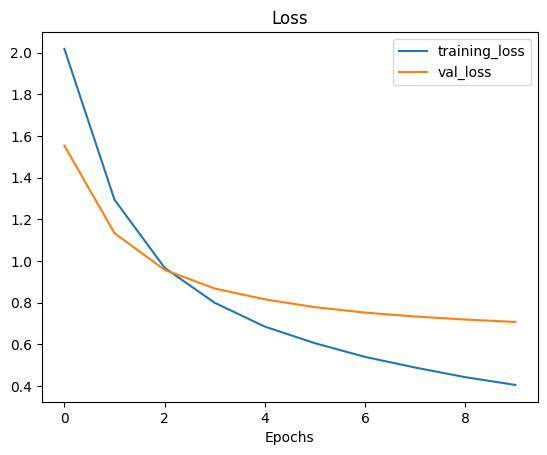

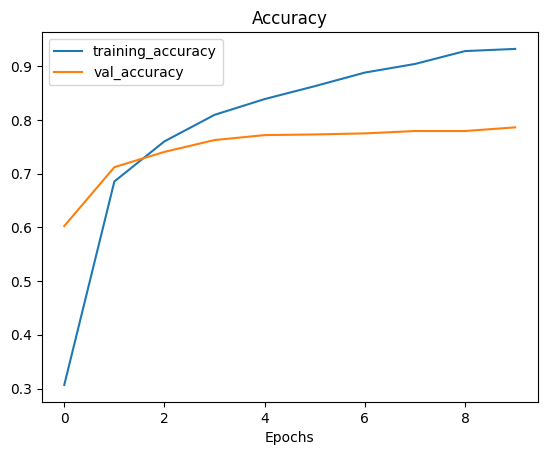

In [22]:
plot_loss_curves(effinet_history)